# 1. Configurations

## 1.1 Install Packages

In [1]:
!pip install colab_ssh

from colab_ssh import launch_ssh_cloudflared
launch_ssh_cloudflared(password='test')

from google.colab import drive
drive.mount('/mnt')

!ln -s /mnt/MyDrive/court-decision-prediction /root
%cd /root/court-decision-prediction

Drive already mounted at /mnt; to attempt to forcibly remount, call drive.mount("/mnt", force_remount=True).
ln: failed to create symbolic link '/root/court-decision-prediction': File exists
/mnt/MyDrive/court-decision-prediction


In [2]:
!pip install transformers==4.30.2 loralib==0.1.1 sentencepiece==0.1.99 livelossplot==0.5.5

In [3]:
!cp /mnt/MyDrive/modeling_llama.py /usr/local/lib/python3.10/dist-packages/transformers/models/llama/modeling_llama.py

Modify file for lora: `/usr/local/lib/python3.10/dist-packages/transformers/models/llama/modeling_llama.py`

https://github.com/microsoft/LoRA#quickstart
```
# ===== Before =====
# layer = nn.Linear(in_features, out_features)

# ===== After ======
import loralib as lora
# Add a pair of low-rank adaptation matrices with rank r=16
layer = lora.Linear(in_features, out_features, r=16)
```

In [4]:
import os
from os.path import join, dirname
import random
import warnings

import numpy as np
import pandas as pd

import torch
from torch import nn

import loralib as lora

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
warnings.filterwarnings('ignore')

## 1.2 Random Seed

In [5]:
def seed_everything(seed: int=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

## 1.3 PATH

In [6]:
class PATH:
    root   = '/root/court-decision-prediction'
    yaml   = join(root, 'court_decision_prediction/configs.yaml')
    data   = join(root, 'data/open')
    train  = join(data, 'train.csv')
    test   = join(data, 'test.csv')
    sample = join(data, 'sample_submission.csv')
    submit = join(root, 'submission')

# 2. Load Dataset

## 2.1 Load Raw Data

In [7]:
train_full_data = pd.read_csv(PATH.train)
test_data       = pd.read_csv(PATH.test)
target          = 'first_party_winner'

## 2.2 Preprocessing
1. Group party into `united states`, `states`, `group1`, `group2`, `indiv`
2. Handle data imbalance
    - Stratified undersampling(`first_party_grp`)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample


def preprocess(data, target):
    data = append_party_group(data)
    if target in data:
        data = undersampling(data, target)
    return data


def append_party_group(data):
    data = data.copy()
    states = list(map(str.lower,
                      ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware',
                       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
                       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
                       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
                       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
                       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
                       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']))
    cities = ['new york', 'los angeles', 'chicago', 'houston', 'phoenix', 'philadelphia', 'san antonio', 'san diego',
              'dallas', 'san francisco', 'oakland', 'austin', 'jacksonville', 'san jose', 'california', 'indianapolis',
              'seattle', 'denver', 'washington', 'boston', 'el paso', 'nashville', 'detroit', 'oklahoma', 'portland',
              'las vegas', 'memphis', 'louisville', 'baltimore', 'milwaukee', 'albuquerque', 'tucson', 'fresno', 'mesa',
              'sacramento', 'atlanta', 'kansas city', 'colorado springs', 'omaha', 'raleigh', 'miami', 'long beach',
              'virginia beach', 'oakland', 'minneapolis', 'tulsa', 'tampa', 'arlington', 'new orleans', 'wichita',
              'cleveland', 'bakersfield', 'aurora', 'anaheim', 'honolulu', 'santa ana', 'riverside', 'corpus christi',
              'lexington', 'stockton', 'anchorage', 'st. paul', 'newark', 'buffalo', 'plano', 'henderson', 'fort wayne',
              'greensboro', 'lincoln', 'glendale', 'chandler', 'st. petersburg', 'jersey city', 'scottsdale', 'norfolk',
              'madison', 'orlando', 'birmingham', 'baton rouge', 'durham', 'laredo', 'garland', 'chula vista',
              'riverside', 'hialeah', 'lubbock', 'reno', 'north las vegas', 'akron', 'gilbert', 'rochester', 'boise',
              'spokane']
    def generate_fn(col):
        def fn(row):
            party = row[col].lower()

            keywords1 = ['united states', 'federal', 'commision', 'commodity', 'national']
            keywords2 = states + cities + ['school board', 'city', 'republic', 'region', 'district', 'county']
            keywords3 = ['corporation', 'inc', 'company', 'bank', 'association', 'llc', 'co.', 'hospital', 'usa', 'school', 'group', 'office', 'department']
            keywords4 = [',', 'et al']

            for grp, keywords in zip(['united states', 'states', 'group1', 'group2'],
                                    [keywords1, keywords2, keywords3, keywords4]):
                for key in keywords:
                    if key in party:
                        return grp
            return 'indiv'
        return fn

    data['first_party_grp']  = data.apply(generate_fn('first_party'), axis=1)
    data['second_party_grp'] = data.apply(generate_fn('second_party'), axis=1)
    return data

def undersampling(data, target):
    data_zero_target = data[data[target] == 0]
    data_one_target  = data[data[target] == 1]
    first_party_grp_int = LabelEncoder().fit_transform(data_one_target['first_party_grp'])
    data_one_target_sample = resample(data_one_target, replace=False, n_samples=len(data_zero_target), stratify=first_party_grp_int)
    return pd.concat([data_zero_target, data_one_target_sample], ignore_index=True)

In [9]:
train_full_data_pp = preprocess(train_full_data, target)
test_data_pp       = preprocess(test_data, target)

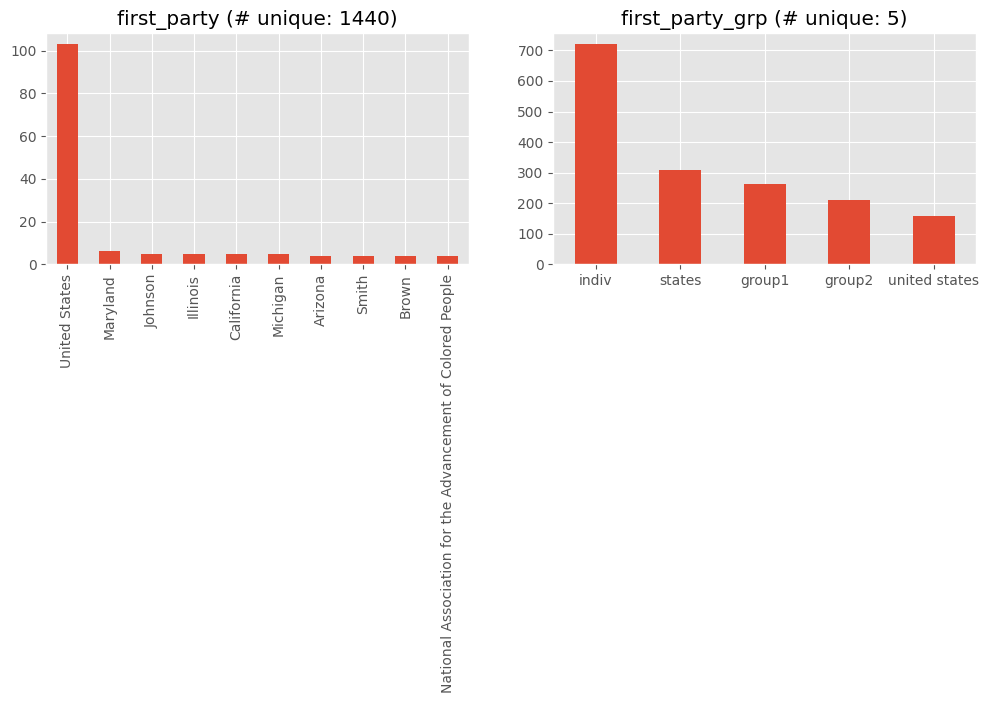

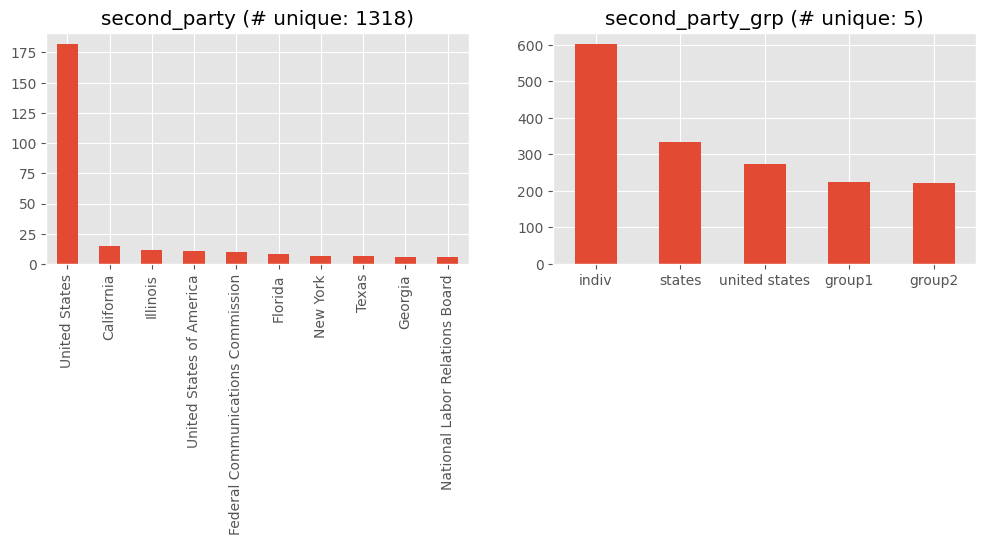

In [10]:
def plot_party(ax1, ax2, f):
    train_full_data_pp[f].value_counts().head(10).plot.bar(ax=ax1),        ax1.set_title(f"{f} (# unique: {train_full_data_pp[f].nunique()})")
    train_full_data_pp[f'{f}_grp'].value_counts().plot.bar(ax=ax2, rot=0), ax2.set_title(f"{f}_grp (# unique: {train_full_data_pp[f+'_grp'].nunique()})")

for f in ('first_party', 'second_party'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
    plot_party(ax1, ax2, f)

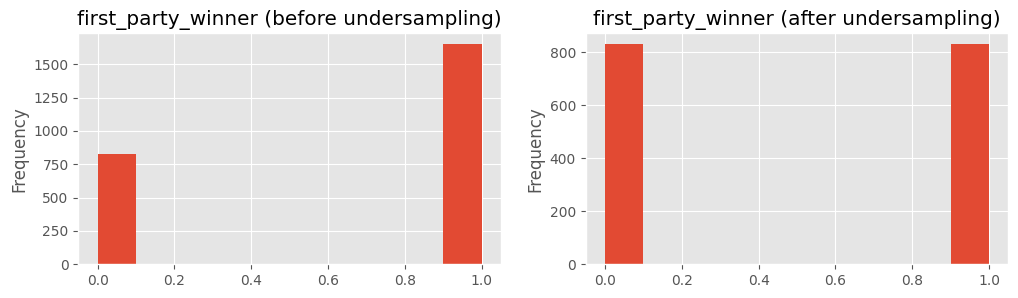

In [11]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3))
train_full_data[target].plot.hist(ax=ax1),    ax1.set_title(f"{target} (before undersampling)")
train_full_data_pp[target].plot.hist(ax=ax2), ax2.set_title(f"{target} (after undersampling)");

## 2.3 Split Dataset

In [12]:
train_full_data_pp = resample(train_full_data_pp, replace=False, n_samples=100, stratify=train_full_data_pp[target])

In [13]:
from sklearn.model_selection import train_test_split

train_data_pp, val_data_pp = train_test_split(train_full_data_pp, test_size=0.3, stratify=train_full_data_pp[target])
len(train_data_pp), len(val_data_pp)

(70, 30)

# 3. Modeling

In [14]:
from transformers import LlamaForCausalLM, LlamaTokenizer

# model_id  = "lmsys/vicuna-7b-v1.3"
model_id  = "openlm-research/open_llama_3b"
# model_id  = "lmsys/fastchat-t5-3b-v1.0"

model     = LlamaForCausalLM.from_pretrained(model_id).to(torch.bfloat16)
tokenizer = LlamaTokenizer.from_pretrained(model_id)

Some weights of LlamaForCausalLM were not initialized from the model checkpoint at openlm-research/open_llama_3b and are newly initialized: ['model.layers.22.self_attn.v_proj.lora_B', 'model.layers.1.mlp.gate_proj.lora_B', 'model.layers.24.mlp.up_proj.lora_B', 'model.layers.0.mlp.gate_proj.lora_B', 'model.layers.4.self_attn.o_proj.lora_B', 'model.layers.17.self_attn.v_proj.lora_A', 'model.layers.7.self_attn.v_proj.lora_B', 'model.layers.14.self_attn.k_proj.lora_B', 'model.layers.24.mlp.gate_proj.lora_B', 'model.layers.6.self_attn.v_proj.lora_B', 'model.layers.18.self_attn.v_proj.lora_B', 'model.layers.20.self_attn.o_proj.lora_A', 'model.layers.6.self_attn.q_proj.lora_B', 'model.layers.14.self_attn.v_proj.lora_B', 'model.layers.5.mlp.up_proj.lora_B', 'model.layers.17.mlp.gate_proj.lora_B', 'model.layers.24.self_attn.v_proj.lora_B', 'model.layers.20.mlp.up_proj.lora_A', 'model.layers.2.self_attn.v_proj.lora_B', 'model.layers.8.mlp.gate_proj.lora_A', 'model.layers.25.self_attn.v_proj.lora

## 3.1 Test Model & Tokenizer

In [15]:
# prompt = f"""Question: What is 1+1?
# Answer: """
# input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
# with torch.no_grad():
#     outputs = model.generate(input_ids=input_ids, max_new_tokens=8)
# response = tokenizer.decode(outputs[0], skip_special_tokens=True)
# print(response)

# print("O:", tokenizer.decode([438, 29949]))   # 29949: _O
# print("X:", tokenizer.decode([1060, 29990]))  # 29990: _X
# print("Start token:", tokenizer.decode([1]))

## 3.2 Modify Model

In [16]:
# Lora setting
model.requires_grad = False
lora.mark_only_lora_as_trainable(model)

# Change trainable head
model.lm_head = nn.Linear(3200, 1)  # 4096: hidden size, 1: binary classification (w.o. sigmoid)
# model.lm_head = nn.Linear(4096, 1)  # 4096: hidden size, 1: binary classification (w.o. sigmoid)
model.lm_head.requires_grad = True
model = model.to(torch.bfloat16).cuda()

In [17]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 3200, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=3200, out_features=3200, bias=False)
          (k_proj): Linear(in_features=3200, out_features=3200, bias=False)
          (v_proj): Linear(in_features=3200, out_features=3200, bias=False)
          (o_proj): Linear(in_features=3200, out_features=3200, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3200, out_features=8640, bias=False)
          (down_proj): Linear(in_features=8640, out_features=3200, bias=False)
          (up_proj): Linear(in_features=3200, out_features=8640, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm(

# 4. Train

In [22]:
from torch.utils.data import Dataset, DataLoader


def get_prompt(first_party, second_party, facts):
    return f"""A chat between a curious user and an artificial intelligence assistant.
The assistant gives helpful and concise answers to the user's questions.

USER:
- first_party: {first_party}
- second_party: {second_party}
- facts:
{facts[:1000]}

- Question: I want to know whether the first_party can win the case. Tell me just the answer with O or X, without any detailed reasons.

ASSISTANT:
- Answer: """

# def get_prompt(first_party, second_party, facts):
#     return f"""
# USER:
# - first_party: {first_party}
# - second_party: {second_party}
# - facts:
# {facts[:1000]}
# - Question: I want to know whether the first_party can win the case. Tell me just the answer with O or X, without any detailed reasons.

# ASSISTANT:
# - Answer: """


# def decode(output):
#     return tokenizer.decode(output[0], skip_special_tokens=True)

class CustomDataset(Dataset):
    def __init__(self, data, target, tokenizer):
        self.data      = data
        self.target    = target

        tokenizer.pad_token = tokenizer.eos_token  # use default pad token
        self.input_ids = self._get_input_ids(data, tokenizer)
        self.labels    = self._get_labels(data)

    def _get_input_ids(self, data, tokenzier):
        prompts = []
        for idx_row in range(len(data)):
            row = self.data.iloc[idx_row]
            prompt = get_prompt(row['first_party'], row['second_party'], row['facts'])
            prompts.append(prompt)
        return tokenizer(prompts, return_tensors='pt', padding='longest').input_ids.cuda()

    def _get_labels(self, data):
        labels = []
        for idx_row in range(len(data)):
            row = data.iloc[idx_row]
            label = row[self.target] if self.target in data else -1  # -1: dummy
            labels.append(label)
        return torch.tensor(labels, dtype=torch.bfloat16).cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input = self.input_ids[idx]
        label = self.labels[idx]
        return input, label


train_ds = CustomDataset(train_data_pp, target, tokenizer)
val_ds   = CustomDataset(val_data_pp, target, tokenizer)
test_ds  = CustomDataset(test_data_pp, target, tokenizer)

train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)
val_dl   = DataLoader(val_ds,   batch_size=1, shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size=1, shuffle=False)

In [23]:
from livelossplot import PlotLosses
from tqdm import trange, tqdm


def compute_loss_acc(X, y):
    output = model(X)
    logit  = output[0][0, -1]  # output of last sequence
    loss   = loss_fn(logit, y)
    acc    = (logit > 0) == y
    return logit, loss, acc

def train_step(X, y):
    logit, loss, acc = compute_loss_acc(X, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return logit.item(), loss.item(), acc.item()

def val_step(X, y):
    logit, loss, acc = compute_loss_acc(X, y)
    return logit.item(), loss.item(), acc.item()


loss_fn   = nn.BCEWithLogitsLoss().cuda()
optimizer = torch.optim.Adam(model.parameters())

liveloss = PlotLosses()
history  = pd.DataFrame(columns=['loss', 'acc', 'val_loss', 'val_acc'], index=pd.Index([], name='Epoch'))
n_epochs = 2
for epoch in trange(1, n_epochs+1):
    logits, losses, accs = [], [], []
    val_logits, val_losses, val_accs = [], [], []

    for X, y in tqdm(train_dl):
        logit, loss, acc = train_step(X, y)
        logits.append(logit), losses.append(loss), accs.append(acc)

    with torch.no_grad():
        for X, y in tqdm(val_dl):
            val_logit, val_loss, val_acc = val_step(X, y)
            val_logits.append(val_logit), val_losses.append(val_loss), val_accs.append(val_acc)

    history.loc[epoch] = [np.mean(losses), np.mean(accs), np.mean(val_losses), np.mean(val_accs)]
    liveloss.update(history.loc[epoch])
    liveloss.send()

  0%|          | 0/2 [00:02<?, ?it/s]


ValueError: ignored

In [24]:
X.size(), y.size()

(torch.Size([2, 373]), torch.Size([2]))

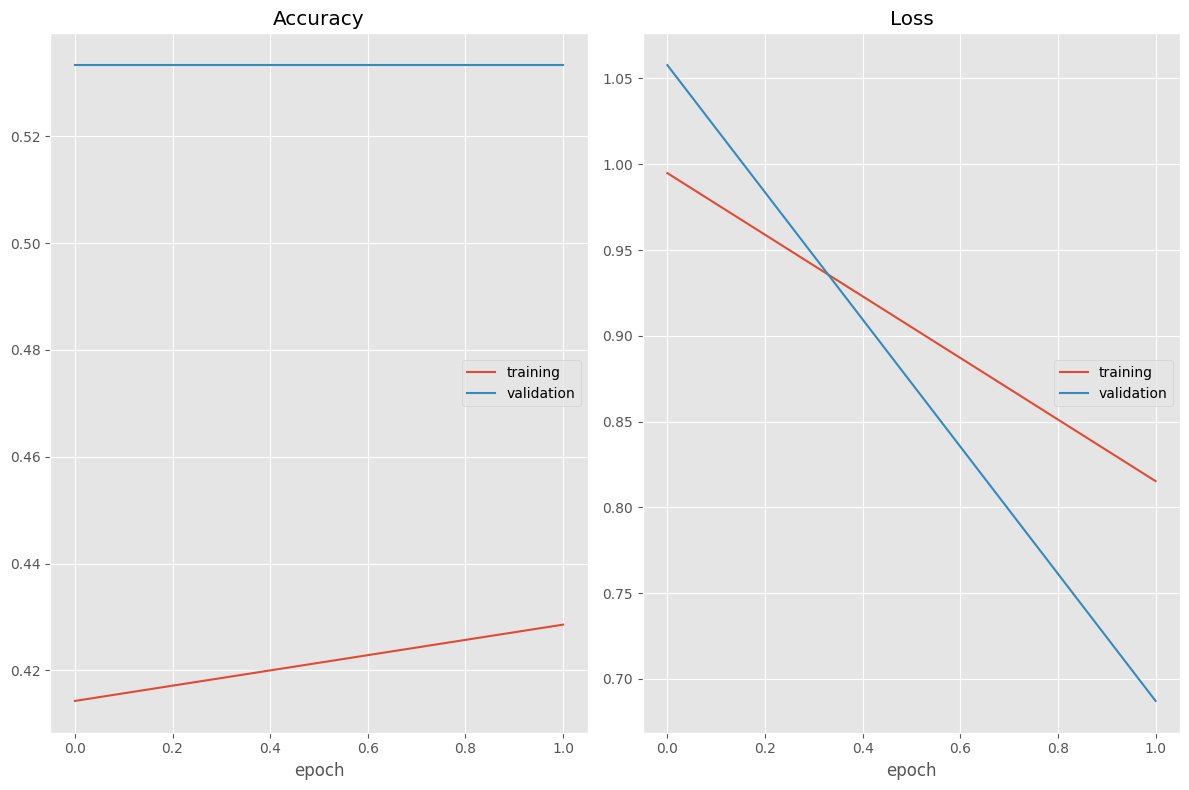

```
100%|██████████| 2/2 [06:56<00:00, 208.40s/it]Accuracy
	training         	 (min:    0.414, max:    0.429, cur:    0.429)
	validation       	 (min:    0.533, max:    0.533, cur:    0.533)
Loss
	training         	 (min:    0.815, max:    0.995, cur:    0.815)
	validation       	 (min:    0.687, max:    1.058, cur:    0.687)
```

In [21]:
!nvidia-smi

Sat Jul  1 05:06:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    34W /  70W |   9623MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------